# MRI Data Preprocessing & Analysis

## Part I: Preprocessing Using FS


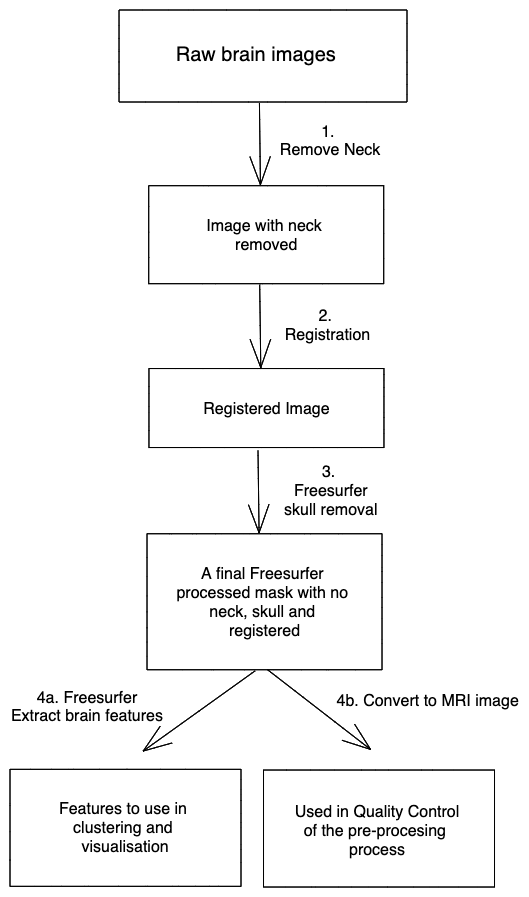

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn import plotting

import warnings
warnings.filterwarnings('ignore')

### Example subject 1

Before Pre-Processing


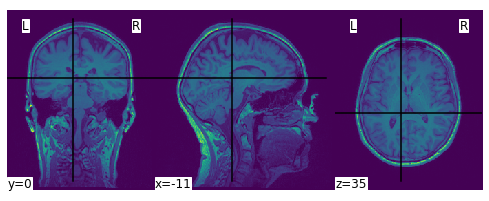

In [53]:
brain_vol = nib.load('DATA_BIDS/sub-0001/anat/sub-0001T1w.nii')

print("Before Pre-Processing")
plotting.plot_img(brain_vol, cut_coords=(-11, 0, 35))
plt.show()

After Pre-Processing


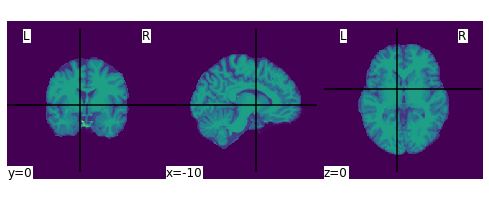

In [43]:
brain_vol = nib.load('DATA_BIDS/sub-0001/anat/sub-0001_reg_skull_neck_removed.nii')

print("After Pre-Processing")
plotting.plot_img(brain_vol, cut_coords=(-10, 0, 0))
plt.show()

### Example subject 2

Before Pre-Processing


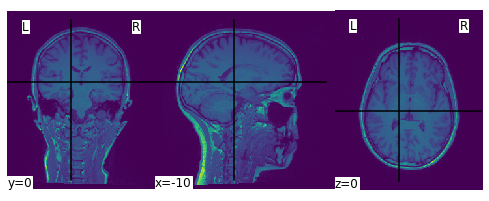

In [42]:
brain_vol = nib.load('DATA_BIDS/sub-0002/anat/sub-0002_T1w.nii')

print("Before Pre-Processing")
plotting.plot_img(brain_vol, cut_coords=(-10, 0, 0))
plt.show()

After Pre-Processing


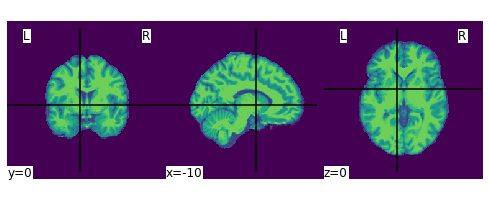

In [40]:
brain_vol = nib.load('DATA_BIDS/sub-0002/anat/sub-0002_reg_skull_neck_removed.nii')

print("After Pre-Processing")
plotting.plot_img(brain_vol, cut_coords=(-10, 0, 0))
plt.show()

### Quality Control
Quality Control was carried as such:

    - Using an average of all the MRIs and detecting the outliars (which are far from this average)
    - Partially manually by examining all the MRIs based on the Freesurfer processed masks to detect really bad cut images

----------------------------------------------------------------------------------------------

## Part II: Data Analysis

### Subjects with T1w image present

Total count: 845
Participants w T1w images count: 424



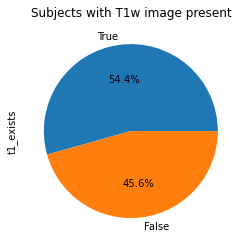

In [20]:
import pandas as pd
import numpy as np
import math

# To hide the warnings from Pandas
import warnings
warnings.filterwarnings('ignore')

data_df = pd.read_csv('files/participants.csv')

print("Total count: {}".format(len(data_df))) # size

actual_participants_df = data_df[data_df.participant_id.str.contains('^[0-9]{5}')]
valid_participants_df = actual_participants_df.loc[actual_participants_df.t1_exists]
# print(valid_participants_df)
print("Participants w T1w images count: {}\n".format(len(valid_participants_df))) # size

actual_participants_df.t1_exists.value_counts().plot(kind='pie',autopct='%1.1f%%', title="Subjects with T1w image present")
plt.show()

---------------------
### AUD-Control

AUD count: 361
Control count: 62



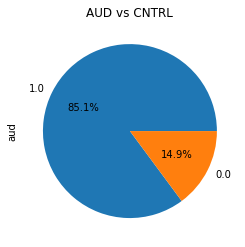

In [21]:
aud_df = valid_participants_df[actual_participants_df.aud == 1] # filter by aud
control_df = valid_participants_df[actual_participants_df.control == 1] # filter by control
print("AUD count: {}".format(len(aud_df))) # size
print("Control count: {}\n".format(len(control_df))) # size

valid_participants_df.aud.value_counts().plot(kind='pie', autopct='%1.1f%%', title="AUD vs CNTRL")
plt.show()

------------------------------
### Age-Sex

Male count: 280
Female count: 144



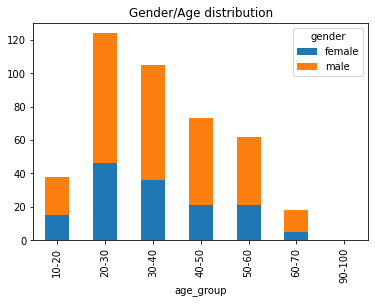

In [22]:
male_df = valid_participants_df[actual_participants_df.gender == 'male'] # filter by aud
female_df = valid_participants_df[actual_participants_df.gender == 'female'] # filter by control
print("Male count: {}".format(len(male_df))) # size
print("Female count: {}\n".format(len(female_df))) # size

df = valid_participants_df[["age", "gender"]]
bins = np.arange(1, 10) * 10
df['category'] = np.digitize(df.age, bins, right=True)

age_group = ["{}-{}".format(x*10, (x+1)*10) for x in df['category']]
df['age_group'] = age_group

counts = df.groupby(['age_group', 'gender']).age.count().unstack()
counts.plot(kind='bar', stacked=True, title="Gender/Age distribution")

plt.show()

------------------------------------------------------
## Now to Find out more about Individual Instruments/Surveys

### 1. ASRS: Adult ADHD Self-Report
Following an AD-HOC calculation for the ASRS score in
https://add.org/wp-content/uploads/2015/03/adhd-questionnaire-ASRS111.pdf


Total count: 3501
Participants count: 424
Number of patients completed ASRS: 401
Number of patients scoring consistent with ADHD: 53



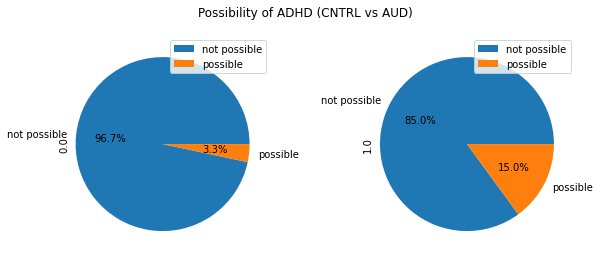

In [19]:
asrs_data_df = pd.read_csv('files/raw/64-At_home_ASRS_LABELS.csv')
asrs_data_main_visit_df = asrs_data_df[asrs_data_df["Event Name"] == "Erhebungszeitpunkt 1"]
completed_asrs_data_df = asrs_data_main_visit_df[asrs_data_df["Complete?"] == "Complete"]

print("Total count: {}".format(len(asrs_data_df)))
print("Participants count: {}".format(len(valid_participants_df))) # size

first_half_score_map = {
    "Niemals" : 0,
    "Selten": 0,
    "Manchmal": 1,
    "Oft": 1,
    "Sehr oft": 1
}

second_half_score_map = {
    "Niemals" : 0,
    "Selten": 0,
    "Manchmal": 0,
    "Oft": 1,
    "Sehr oft": 1
}

asrs_columns = {
    1: "Wie oft haben Sie Probleme, die letzten Details eines Projekts abzuschließen, nachdem die schwierigen Teile abgeschlossen sind?",
    2: "Wie oft haben Sie Schwierigkeiten, Dinge zu ordnen, wenn Sie eine Aufgabe haben, die Organisation erfordert?",
    3: "Wie oft haben Sie Probleme, sich an Termine oder Verpflichtungen zu erinnern?",
    4: "Wie oft vermeiden oder verschieben Sie es, eine Aufgabe zu beginnen, die viel Nachdenken erfordert?",
    5: "Wie oft sind Sie zappelig oder bewegen die Hände oder Füße, wenn Sie lange Zeit sitzen müssen?",
    6: "Wie oft fühlen Sie sich übermäßig aktiv und unter dem Zwang, Dinge zu tun, als ob Sie von einem Motor angetrieben wären?"
}

def asrs_score(a1, a2, a3, a4, a5, a6):
    if not a1 in first_half_score_map.keys():
        return -1
    first_half_score = first_half_score_map[a1] + first_half_score_map[a2] + first_half_score_map[a3];
    second_half_score = second_half_score_map[a4] + second_half_score_map[a5] + second_half_score_map[a6];
    return first_half_score + second_half_score;

def asrs_rating(score):
    if score >= 4:
        return "possible";
    else:
        return "not possible";

asrs_score = [asrs_score(row[0],row[1],row[2],row[3],row[4],row[5]) for row in \
         asrs_data_main_visit_df[
            [asrs_columns[1], asrs_columns[2], asrs_columns[3], asrs_columns[4], asrs_columns[5], asrs_columns[6]]
        ].to_numpy()]
asrs_rating = [asrs_rating(score) for score in asrs_score] 

asrs_data_main_visit_df['asrs_score'] = asrs_score
asrs_data_main_visit_df['asrs_rating'] = asrs_rating

intermediate = asrs_data_main_visit_df[["Participant ID", "asrs_score", "asrs_rating"]]

merged_results = pd.merge(valid_participants_df, intermediate, left_on="participant_id", right_on="Participant ID")
asrs_completed_participants = merged_results[merged_results["asrs_score"] > -1]
adhd_participants = asrs_completed_participants[merged_results["asrs_score"] >= 4]

# print(merged_results)

asrs_completed_participants
print("Number of patients completed ASRS: {}".format(len(asrs_completed_participants)))
print("Number of patients scoring consistent with ADHD: {}\n".format(len(adhd_participants)))

axes = asrs_completed_participants.groupby(['asrs_rating', 'aud']).size().unstack().plot(kind='pie', figsize=[10, 4], autopct='%1.1f%%', subplots=True, title="Possibility of ADHD (CNTRL vs AUD)")
for ax in axes:
    ax.set_aspect('equal')
    ax.yaxis.labelpad = -15


--------------------------------------------
### 2. PSS-10: Perceived Stress Scale
https://das.nh.gov/wellness/docs/percieved%20stress%20scale.pdf


Total Count: 4094
Completed PSS count: 589

Total valid Participants count: 424
Completed PSS valid participants count: 408



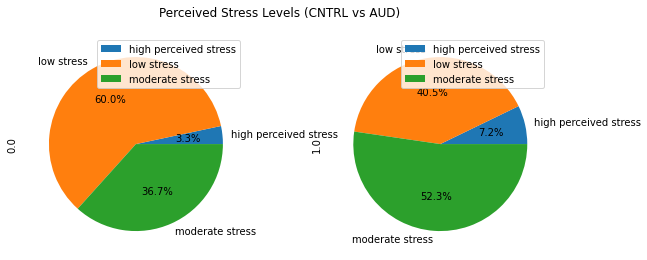

In [25]:
pss_data_df = pd.read_csv('files/raw/71-At_home_PSS-10_LABELS.csv')
pss_data_main_visit_df = pss_data_df[pss_data_df["Event Name"] == "Erhebungszeitpunkt 1"]
completed_pss_data_df = pss_data_main_visit_df[pss_data_df["Complete?"] == "Complete"]

print("Total Count: {}".format(len(pss_data_df)))
print("Completed PSS count: {}".format(len(completed_pss_data_df))) # size

pss_score_mapping = {
    "Nie" : 0,
    "Fast nie": 1,
    "Manchmal": 2,
    "Ziemlich oft": 3,
    "Sehr oft": 4
}

pss_rating = {
    13: "low stress",
    26: "moderate stress",
    13: "high perceived stress"
}

pss_columns = {
    1: "Wie oft waren Sie im letzten Monat aufgewühlt, weil etwas unerwartet passiert ist?",
    2: "Wie oft hatten Sie im letzten Monat das Gefühl, nicht in der Lage zu sein, die wichtigen Dinge in Ihrem Leben kontrollieren zu können?",
    3: "Wie oft haben sie sich im letzten Monat nervös und gestresst gefühlt?",
    4: "Wie oft waren Sie im letzten Monat zuversichtlich, dass Sie fähig sind, ihre persönlichen Probleme zu bewältigen?",
    5: "Wie oft hatten Sie im letzten Monat das Gefühl, dass sich die Dinge zu Ihren Gunsten entwickeln?",
    6: "Wie oft hatten Sie im letzten Monat den Eindruck, nicht all Ihren anstehenden Aufgaben gewachsen zu sein?",
    7: "Wie oft waren Sie im letzten Monat in der Lage, ärgerliche Situationen in Ihrem Leben zu beeinflussen?",
    8: "Wie oft hatten Sie im letzten Monat das Gefühl, alles im Griff zu haben?",
    9: "Wie oft haben Sie sich im letzten Monat über Dinge geärgert, über die Sie keine Kontrolle hatten?",
    10: "Wie oft hatten Sie im letzten Monat das Gefühl, dass sich so viele Schwierigkeiten angehäuft haben, dass Sie diese nicht überwinden konnten?",
    11: "Complete?"
}
# print(pss_data_main_visit_df)

columns_to_keep = [1,2,3,6,9,10]
columns_to_reverse = [4,5,7,8]
start_of_pss_columns = 5;
def pss_score(row):
    if not row[-1] == "Complete":
        return -1;
    total_score = 0;
    for column in columns_to_keep:
        df_column_index = start_of_pss_columns + column
        total_score += pss_score_mapping[row[df_column_index]]
    for column in columns_to_reverse:
        df_column_index = start_of_pss_columns + column
        total_score += (4-pss_score_mapping[row[df_column_index]])
    return total_score;

def pss_rating(score):
    if score <= 13:
        return "low stress";
    elif score <= 26:
        return "moderate stress";
    else:
        return "high perceived stress";

pss_score = [pss_score(row) for _,row in pss_data_main_visit_df.iterrows()]
pss_rating = [pss_rating(score) for score in pss_score]
pss_data_main_visit_df['pss_score'] = pss_score
pss_data_main_visit_df['pss_rating'] = pss_rating

intermediate = pss_data_main_visit_df[["Participant ID", "pss_score", "pss_rating"]]

merged_results_pss = pd.merge(valid_participants_df, intermediate, left_on="participant_id", right_on="Participant ID")
pss_completed_participants = merged_results_pss[merged_results_pss["pss_score"] > -1]

print("\nTotal valid Participants count: {}".format(len(valid_participants_df))) # size
print("Completed PSS valid participants count: {}\n".format(len(pss_completed_participants)))

# pss_completed_participants.groupby(['aud','pss_rating']).size().unstack().plot(kind='barh')
axes = pss_completed_participants.groupby(['pss_rating','aud']).size().unstack().plot(kind='pie', figsize=[10, 4], autopct='%1.1f%%', subplots=True, title="Perceived Stress Levels (CNTRL vs AUD)")
for ax in axes:
    ax.set_aspect('equal')
    ax.yaxis.labelpad = 10
    ax.xaxis.labelpad = 200



------------------

### 3. Site Distribution


Total count: 867

Total valid Participants count: 424



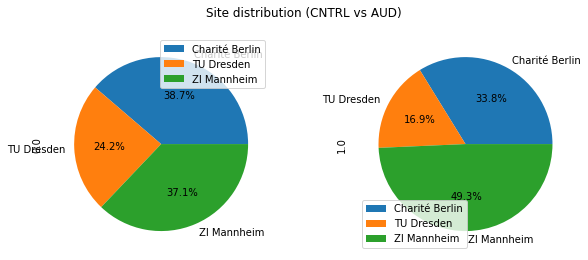

In [28]:
site_data_df = pd.read_csv('files/raw/1-Clinic_Examiner_Preparatory_Questions_LABELS.csv')
site_data_main_visit_df = site_data_df[site_data_df["Event Name"] == "Erhebungszeitpunkt 1"]

print("Total count: {}".format(len(site_data_main_visit_df)))

intermediate = site_data_main_visit_df[["Participant ID", "Erhebendes Zentrum"]]

merged_site_results = pd.merge(valid_participants_df, intermediate, left_on="participant_id", right_on="Participant ID")

print("\nTotal valid Participants count: {}\n".format(len(valid_participants_df))) # size

# pss_completed_participants.groupby(['aud','pss_rating']).size().unstack().plot(kind='barh')
axes = merged_site_results.groupby(['Erhebendes Zentrum','aud']).size().unstack().plot(kind='pie', figsize=[10, 4], autopct='%1.1f%%', subplots=True, title="Site distribution (CNTRL vs AUD)")
for ax in axes:
    ax.set_aspect('equal')
    ax.yaxis.labelpad = 10
    ax.xaxis.labelpad = 200



---------------------------------------

### 4. Understanding which behavioural survey data is useful


In [16]:
import pprint
from os import listdir
from os.path import isfile, join
dir_path = 'files/raw/'

results = []
for file in listdir(dir_path):
    data_df = pd.read_csv("files/raw/{}".format(file))
    main_visit_df = data_df[data_df["Event Name"] == "Erhebungszeitpunkt 1"]
    completed_data_df = main_visit_df[main_visit_df["Complete?"] == "Complete"]
    merged_w_valid = pd.merge(valid_participants_df, completed_data_df, left_on="participant_id", right_on="Participant ID")
    results.append({ "file": file, "completed_entries": len(completed_data_df), "completed_w_valid_t1": len(merged_w_valid)})

def sort_results(res):
    return int(res["file"].split("-")[0]);

results.sort(key=sort_results)
df = pd.DataFrame.from_records(results)
df.style.bar(subset=['completed_w_valid_t1'], color='#d65f5f')


,file,completed_entries,completed_w_valid_t1
0,1-Clinic_Examiner_Preparatory_Questions_LABELS.csv,806,422
1,2-Clinic_Examiner_MRT_Suitability_LABELS.csv,659,416
2,3-Clinic_Examiner_ASSIST_LABELS.csv,788,423
3,4-Clinic_Examiner_ASSIST_follow-up_LABELS.csv,0,0
4,5-Clinic_Examiner_Quantity_Frequency_Alkohol_LABELS.csv,769,423
5,6-Clinic_Examiner_Quantity_Frequency_Alkohol_follow-up_LABELS.csv,0,0
6,7-Clinic_Examiner_Quantity_Frequency_Tabak-E-Zigarette_LABELS.csv,731,412
7,8-Clinic_Examiner_Quantity_Frequency_Tabak-E-Zigarette_follow-up_LABELS.csv,0,0
8,9-Clinic_Examiner_Quantity_Frequency_Cannabis-Andere_LABELS.csv,707,394
9,10-Clinic_Examiner_Quantity_Frequency_Cannabis-Andere_follow-up_LABELS.csv,0,0
